## Catboost model implemententation for Diabetes prediction 
**Was created by:** Matsvei Makhnou<br><br>
**Short description:** <br>In this notebook I will implement Catboost model for diabetes prediction. I will use Optuna for hyperparameter tuning and ML flow for tracking the experiments.<br>
**Lib you need to install to run this code:** <br>catboost, optuna, mlflow, pandas, numpy, scikit-learn, shap<br>
#### Section for novigating through the notebook: 
[Data preprocessing](#data-preprocessing) - Data loading and preprocessing <br>
[Model training](#model_training) - Model training, hyperparameter tuning and training process tracking <br>
[Final model training](#final_model_training) - Final model training with best hyperparameters <br>
[Result interpretation Using SHAP](#result_interpretation) - In this section I will interpret the results of the model using SHAP lib and plot the feature importance<br>
[Conclusion](#conclusion) - Conclusion and future work <br>




In [ ]:
import pandas as pd

from sklearn.model_selection import train_test_split
from modules.with_class_balanced import run_optimization
from modules.final_training import run_final_training

import shap

### <a id =  'data-preprocessing'> Data preprocessing </a> 
In our situation we have imbalanced dataset so during the model trainng I will use class weight parameter to balance the dataset.
In this section I will load the data and split it into train, validation and test sets.

In [2]:
df = pd.read_csv("diabetes_dataset.csv")

X = df.drop(columns=["Outcome"])
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42
)

print(f"For train: {y_train.value_counts()}")
print(f"For valid: {y_valid.value_counts()}")
print(f"For test: {y_test.value_counts()}")

For train: Outcome
0    3731
1    1991
Name: count, dtype: int64
For valid: Outcome
0    1250
1     658
Name: count, dtype: int64
For test: Outcome
0    1275
1     633
Name: count, dtype: int64


### <a id =  'model_training'> Model training </a>
In this section I will train the  catboost model and tune the hyperparameters using optuna. Using ML flow I will track the experiments and save the best model.

In [ ]:
study = run_optimization(
    X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid
)
print(f"Best params for balanced class weight: {study.best_params}")

2025/02/28 11:18:56 INFO mlflow.tracking.fluent: Experiment with name 'With_class_balanced' does not exist. Creating a new experiment.
[I 2025-02-28 11:18:56,971] A new study created in memory with name: no-name-318560ac-4bff-403f-ba47-f99b415da46e
2025/02/28 11:19:51 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/02/28 11:19:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
[I 2025-02-28 11:19:52,650] Trial 0 finished with value: 0.9999975683890576 and parameters: {'iterations': 288, 'learning_rate': 0.28597960857135685, 'depth': 8, 'l2_leaf_reg': 9.418801730563711, 'subsample': 0.8614250596901208}. Best is trial 0 with value: 0.9999975683890576.
2025/02/28 11:20:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip

Best params for balanced class weight: {'iterations': 304, 'learning_rate': 0.06142931939577834, 'depth': 8, 'l2_leaf_reg': 3.1379883995374893, 'subsample': 0.693900781099302}


### <a id =  'final_model_training'> Final model training </a>
In this section I will train the final model using the best parameters found in the previous section. Before we'll start training the final model, we'll concatenate the training and validation sets to create a larger training set. This will help the model generalize better to unseen data.

In [3]:
X_final_train = pd.concat([X_train, X_valid])
y_final_train = pd.concat([y_train, y_valid])

In [ ]:
model, f1, auc, precision, recall, accuracy = run_final_training(
    X_final_train, y_final_train, X_test, y_test
)

print(f"Final model: {model}")
print(f"F1 score: {f1}")
print(f"AUC: {auc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"Accuracy: {accuracy}")

2025/03/03 13:13:58 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/03 13:13:58 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Final model: <catboost.core.CatBoostClassifier object at 0x7fdbe60bbcb0>
F1 score: 0.9992094861660079
AUC: 0.9999975219155592
Precision: 1.0
Recall: 0.9984202211690363
Accuracy: 0.999475890985325


### <a id =  'result_interpretation'> Result Interpretation using SHAP</a>
In this section I will interpret the results of the model. I will use SHAP values to interpret the results of the model. SHAP values are a game theoretic approach to explain the output of any machine learning model.


shap_values: [[ 4.44699281e-02  1.18403974e-02 -5.30463186e-03 -1.81685807e-01
  -3.44922551e-02  2.08395096e-02  4.64056060e-03  4.32426771e-02
   4.87167613e-02  5.96789725e-02 -2.84553194e-03  3.89809850e-02
   9.53905921e+00  3.31031290e-02  1.55415085e-04 -3.79974092e-03]]


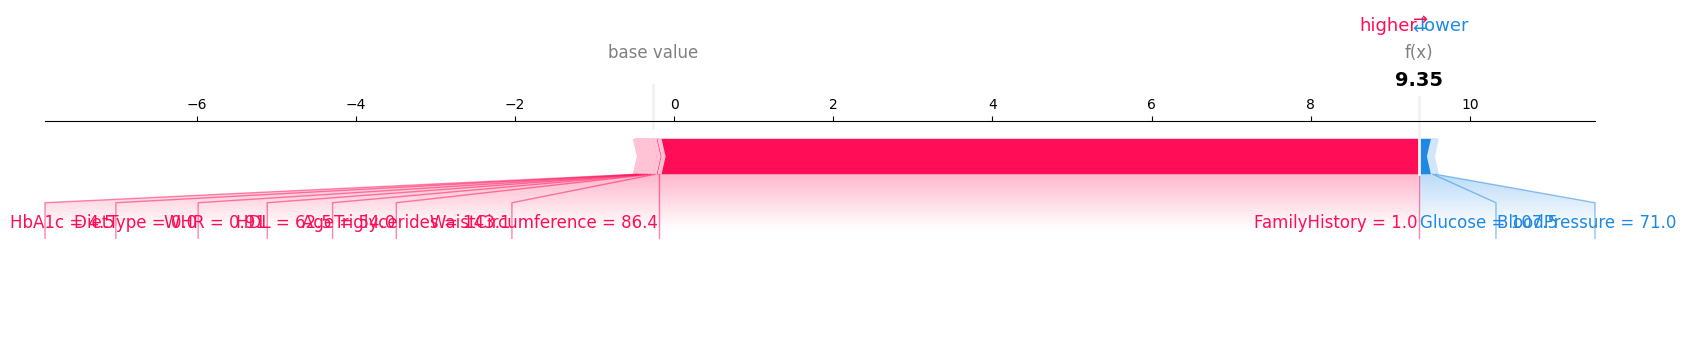

In [51]:
explainer = shap.TreeExplainer(model)

sample = X_test.iloc[[1]]
shap_values = explainer.shap_values(sample)
print(f"shap_values: {shap_values}")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, sample, matplotlib=True)

The **base value** represents the model’s expected output, and the final prediction (9.35) is obtained by adding the SHAP values of all features.  

**Red features (positive SHAP values)**: These **increase** the model's prediction.  
 **FamilyHistory = 1** has a significant positive impact, pushing the prediction higher.  
 Other features like **Glucose, BloodPressure, and HbA1c** also contribute positively.  

**Blue features (negative SHAP values)**: These **decrease** the model's prediction.  

The length of each bar represents the magnitude of the SHAP value, meaning **FamilyHistory = 1 had one of the strongest effects** in raising the final prediction.  

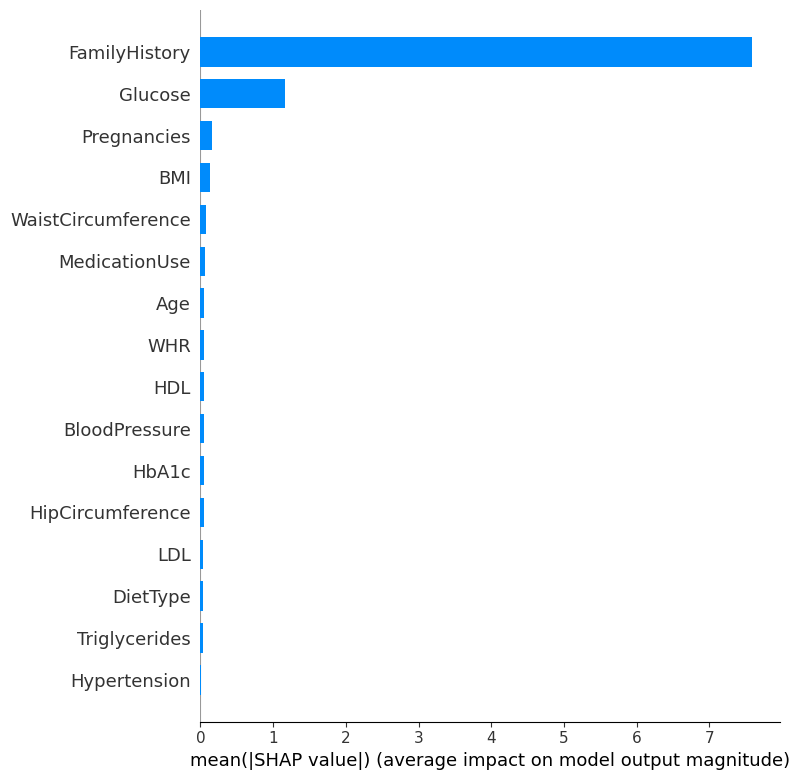

In [57]:
# here I'm using the whole test set to get the summary plot
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

As we can clearly see above, the highest impact comes from the `FamilyHistory` and `Glucose` features. This means these features are the most important for our model's predictions. When trying to identify people with diabetes, pay attention to these features.  We can also see that most people with diabetes have a `FamilyHistory` of the disease and high `Glucose` levels.

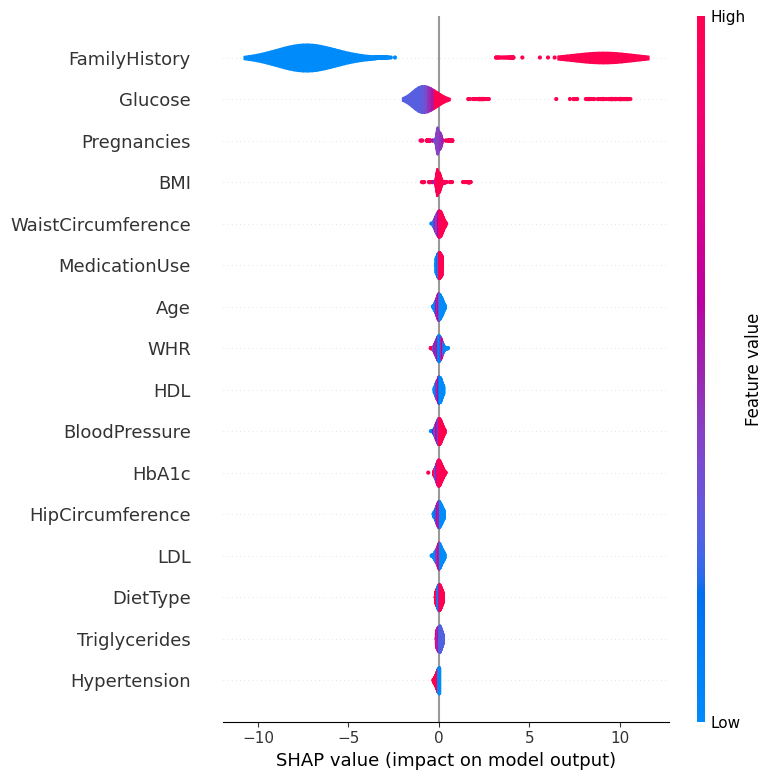

In [58]:
shap.summary_plot(shap_values, X_test, plot_type="violin")

In short, this SHAP summary plot provides a much richer understanding of the model's behavior than the bar plot alone. It not only confirms the importance of FamilyHistory and Glucose but also reveals the direction and distribution of the impact of all features on the prediction of diabetes, including potential feature interactions. It allows for more nuanced insights into how the model arrives at its predictions.

### <a id =  'conclusion'> Conclusion </a> 
This notebook demonstrates the effective application of CatBoost for diabetes prediction.  By leveraging `Optuna` for hyperparameter tuning and `MLflow` for experiment tracking, we achieved a robust and optimized model. `SHAP values` provided valuable insights into feature importance, highlighting the significance of FamilyHistory and Glucose in predicting diabetes.  Future work could explore incorporating additional features or experimenting with different model architectures to potentially improve predictive performance further.